### Random Foreset Classification

#### Import library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Import dataset

In [3]:
#hearing tests
df = pd.read_csv('hearing_test.csv')
df

,age,physical_score,test_result
0,33.0,40.7,1
1,50.0,37.2,1
2,52.0,24.7,0
3,56.0,31.0,0
4,35.0,42.9,1
...,...,...,...
4995,73.0,3.9,0
4996,57.0,33.9,1
4997,49.0,34.5,1
4998,38.0,46.4,1


In [4]:
df.isnull().sum()

age               0
physical_score    0
test_result       0
dtype: int64

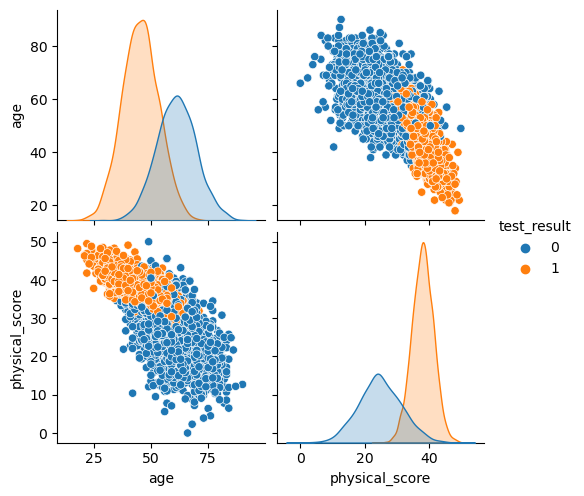

In [5]:
sns.pairplot(df, hue='test_result')  #the nice separation between the test results should be give us a good prediction

#### Separate X features & y labels

In [6]:
X = df.drop('test_result', axis=1)
y = df['test_result']

#### Split Training/Test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

#### Train the model

In [8]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 10, max_features = 'auto', random_state=101, criterion = 'gini') 
                                #Default parameters
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=101)

#### Test the model

In [9]:
y_pred = model.predict(X_test)
new_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
new_df.sample(5)

,y_test,y_pred
498,1,1
4120,1,1
415,0,0
4957,1,1
372,0,0


#### Evaluate the model

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

#model.coef_  #not available for Decision Tree

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f"Precision Score: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

Accuracy Score: 0.914
Precision Score: 0.9143093447905478
Recall Score: 0.914
F1 Score: 0.9141204902410395


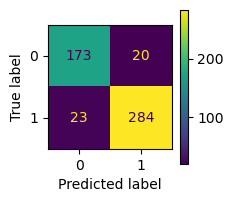

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test).figure_.set_size_inches(2, 2)
plt.show()

In [12]:
confusion_matrix(y_test, y_pred)

array([[173,  20],
       [ 23, 284]], dtype=int64)

In [13]:
report = classification_report(y_test, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report # this breaks down the metrics by class 

,precision,recall,f1-score,support
0,0.882653,0.896373,0.889460,193.000
1,0.934211,0.925081,0.929624,307.000
accuracy,0.914000,0.914000,0.914000,0.914
macro avg,0.908432,0.910727,0.909542,500.000
weighted avg,0.914309,0.914000,0.914120,500.000


#### What are the most important X features?

In [14]:
pd.DataFrame(index=X.columns, data=model.feature_importances_, 
             columns=['Feature Importance']).sort_values('Feature Importance')
#physical_score is the most important feature

,Feature Importance
age,0.344473
physical_score,0.655527


#### Visualize

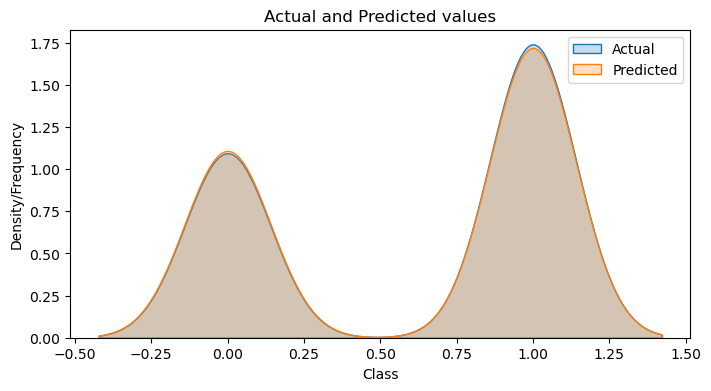

In [15]:
plt.figure(figsize=(8, 4))

sns.kdeplot(y_test, label='Actual', shade=True)
sns.kdeplot(y_pred, label='Predicted', shade=True)

plt.title('Actual and Predicted values')
plt.xlabel('Class')
plt.ylabel('Density/Frequency')
plt.legend()
plt.show()

# y_test & y_pred largely overlap, thus the predictions are closely aligned with the actual values.

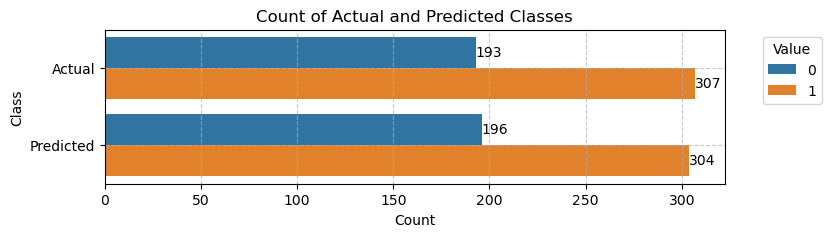

In [16]:
# Combine y_test and y_pred into a single DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot the counts of each class
plt.figure(figsize=(8, 2))
plot = sns.countplot(y='variable', hue='value', data=pd.melt(comparison_df))

# Add counts on top of the bars
for p in plot.patches:
    plot.annotate(format(p.get_width(), '.0f'), 
                  (p.get_width(), p.get_y() + p.get_height() / 2.), 
                  ha = 'center', va = 'center', 
                  xytext = (9, 0), 
                  textcoords = 'offset points')

plt.legend(title='Value', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.title('Count of Actual and Predicted Classes')
plt.ylabel('Class')
plt.xlabel('Count')
plt.show()

#### Predict future patient

In [17]:
model.predict([[33, 40]])
#if patient is age 33 and has physical score of 40, then they will pass the hearing test

C:\Users\btemo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)

#### Grid Search with Cross Validation to see what metrics work best

In [18]:
from sklearn.model_selection import GridSearchCV

n_estimators = [64, 100, 128, 200]
max_features = [2, 3, 4]
bootstrap = [True, False]
oob_score = [True, False]

param_grid = {'n_estimators': n_estimators, 
             'max_features': max_features, 
             'bootstrap': bootstrap,
             'oob_score': oob_score}

model = RandomForestClassifier()
grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

grid.best_params_

C:\Users\btemo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\btemo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\btemo\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\btemo\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\btemo\anaconda3\lib\site-packages\

{'bootstrap': True, 'max_features': 2, 'n_estimators': 200, 'oob_score': False}

In [19]:
#Lets try the new parameters and see how much it improves the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

model = RandomForestClassifier(n_estimators = 128, max_features = 2, bootstrap=True, oob_score=False) 
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
new_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print(f"Precision Score: {precision_score(y_test, y_pred, average='weighted')}")
print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")



Accuracy Score: 0.912
Precision Score: 0.9118579440519154
Recall Score: 0.912
F1 Score: 0.9119136904761905


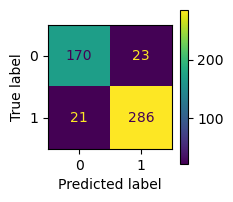

In [20]:
#Prior results:
# Accuracy Score: 0.914
# Precision Score: 0.9143093447905478
# Recall Score: 0.914
# F1 Score: 0.9141204902410395
#it didn't improve
    
    
plot_confusion_matrix(model, X_test, y_test).figure_.set_size_inches(2, 2)
plt.show()

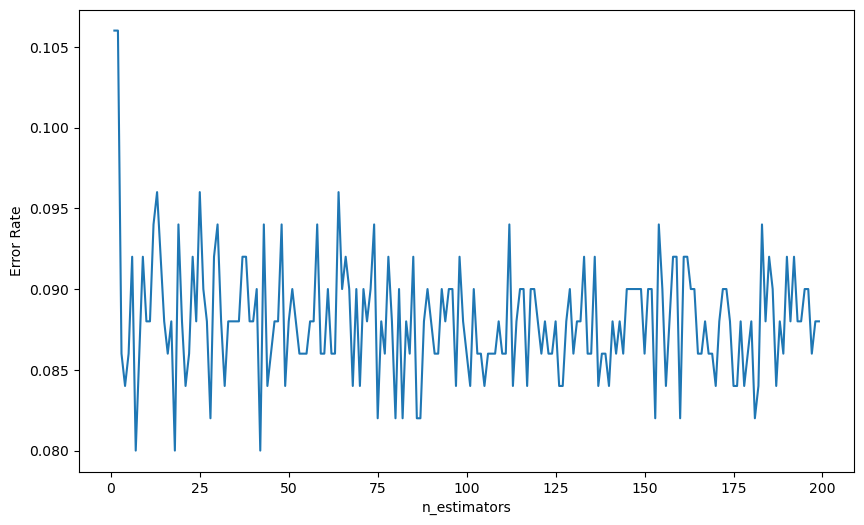

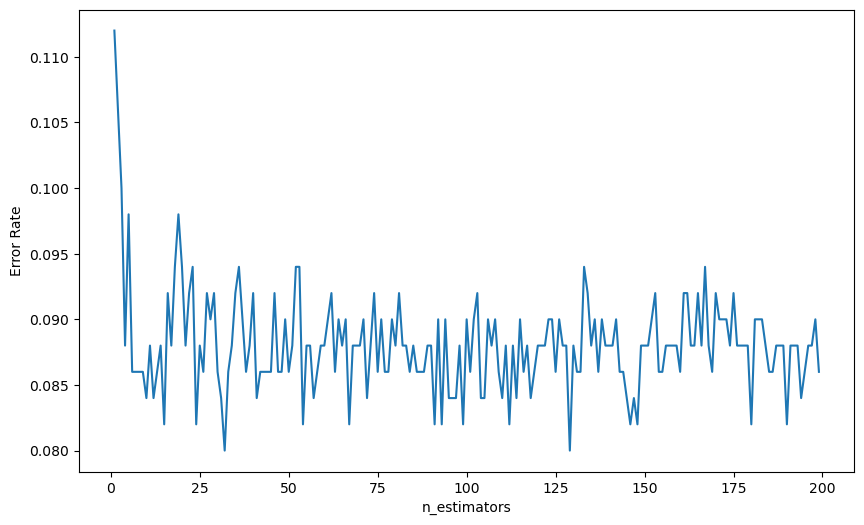

In [24]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(10, 6))


test_error_rates = []

for n in range(1, 200):
    model = RandomForestClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    
    test_error_rates.append(test_error)
    
#visualize
plt.plot(range(1, 200), test_error_rates)
plt.xlabel('n_estimators')
plt.ylabel('Error Rate')

plt.show()
